In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 25.6 MB/s 
     |████████████████████████████████| 7.6 MB 39.5 MB/s 


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import f1_score, average_precision_score
import pandas as pd
import numpy as np
import pickle
from keras.layers import Dense, Dropout
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.regularizers import l2

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
data = pd.read_excel('final_labels.xlsx')

In [ ]:
for i in data.index:
  c1 = tokenizer(data.loc[i, 'C1'], return_tensors="pt")
  c2 = tokenizer(data.loc[i, 'C2'], return_tensors="pt")
  c3 = tokenizer(data.loc[i, 'C3'], return_tensors="pt")
  try:
    emb1, emb2, emb3 = model(**c1, output_hidden_states=True)['last_hidden_state'][:,0,:].detach().numpy(), model(**c2, output_hidden_states=True)['last_hidden_state'][:,0,:].detach().numpy(), model(**c3, output_hidden_states=True)['last_hidden_state'][:,0,:].detach().numpy()
  except:
    continue
  chain_emb = np.concatenate([emb1, emb2, emb3], axis = 1)
  if i == 0:
    X = chain_emb
    Y_ag = np.array(data.loc[i,'Agree']).reshape(-1,1)
    Y_ci = np.array(data.loc[i,'Civil']).reshape(-1,1)
    Y_se = np.array(data.loc[i,'Serious']).reshape(-1,1)
  else:
    X = np.concatenate([X, chain_emb])
    Y_ag = np.concatenate([Y_ag, np.array(data.loc[i,'Agree']).reshape(-1,1)])
    Y_ci = np.concatenate([Y_ci, np.array(data.loc[i,'Civil']).reshape(-1,1)])
    Y_se = np.concatenate([Y_se, np.array(data.loc[i,'Serious']).reshape(-1,1)])


NameError: ignored

In [ ]:
out = {'emb': X, 'Y_ag': Y_ag, 'Y_ci': Y_ci, 'Y_se': Y_se}
with open('labeled_emb.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('final_emb.pickle', 'rb') as f:
    labels = pickle.load(f)

In [ ]:
X = labels['emb']
Y_ag = np.array(data['ag']).reshape(-1,1)
Y_ci = np.array(data['ci']).reshape(-1,1)
Y_se = np.array(data['se']).reshape(-1,1)

In [ ]:
# X_train, X_test, Y_ag_train, Y_ag_test = train_test_split(X, Y_ag, random_state = 1, test_size = 0.1)
# X_train, X_test, Y_ci_train, Y_ci_test = train_test_split(X, Y_ci, random_state = 1, test_size = 0.1)
# X_train, X_test, Y_se_train, Y_se_test = train_test_split(X, Y_se, random_state = 1, test_size = 0.1)
X_train = X
Y_ag_train = Y_ag
Y_ci_train = Y_ci
Y_se_train = Y_se

In [ ]:
def create_model():
  model = Sequential(
      [
          Dense(150, activation="softplus", name="layer1", input_shape=(2304,), kernel_regularizer= l2(0.01)),
          Dropout(0.1),
          Dense(150, activation="softplus", name="layer2", kernel_regularizer= l2(0.01)),
          Dropout(0.1),
          Dense(1, activation = 'sigmoid',name="layer3"),
      ]
  )
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_multitask_model():
  model = Sequential(
      [
          Dense(250, activation="softplus", name="layer1", input_shape=(2304,), kernel_regularizer= l2(0.01)),
          Dropout(0.1),
          Dense(250, activation="softplus", name="layer2", kernel_regularizer= l2(0.01)),
          Dropout(0.1),
          Dense(3, activation = 'sigmoid',name="layer3"),
      ]
  )
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


In [ ]:
kf = KFold(n_splits=10)
f = 1
rf_results = pd.DataFrame()
nn_results = pd.DataFrame()
mt_results = pd.DataFrame()

nn_ag_best = None
nn_se_best = None
nn_ci_best = None

rf_ag_best = None
rf_se_best = None
rf_ci_best = None

mt_best = None

for train_index, test_index in kf.split(X_train):
  clf_res_dict = {}
  nn_res_dict = {}
  mt_res_dict = {}

  x = X_train[train_index]
  y_ag = Y_ag_train[train_index]
  y_ci = Y_ci_train[train_index]
  y_se = Y_se_train[train_index]

  x_t = X_train[test_index]
  y_t_ag = Y_ag_train[test_index]
  y_t_ci = Y_ci_train[test_index]
  y_t_se = Y_se_train[test_index]
  
  print('Training random forest...')
  clf_ag = RandomForestClassifier(max_depth=3, random_state=2, n_estimators=300)
  clf_ag.fit(x, y_ag.reshape(-1,))
  clf_ci = RandomForestClassifier(max_depth=3, random_state=2, n_estimators=300)
  clf_ci.fit(x, y_ci.reshape(-1,))
  clf_se = RandomForestClassifier(max_depth=3, random_state=2, n_estimators=300)
  clf_se.fit(x, y_se.reshape(-1,))

  print('Training multitask...')
  mt_nn = create_multitask_model()
  multi_y = np.concatenate([y_ag, y_ci, y_se], axis = 1)
  mt_nn.fit(x, multi_y, epochs = 100, verbose = 0)

  print('Training single-task NNs...')
  nn_ag = create_model()
  nn_ag.fit(x, y_ag.reshape(-1,), epochs = 100, verbose = 0)
  nn_ci = create_model()
  nn_ci.fit(x, y_ci.reshape(-1,), epochs = 100, verbose = 0)
  nn_se = create_model()
  nn_se.fit(x, y_se.reshape(-1,), epochs = 100, verbose = 0)

  
  print(f'Fold {f} ----------------------')
  print('Agreement')
  test_pred = clf_ag.predict(x_t)
  train_pred = clf_ag.predict(x)
  clf_res_dict['ag_train'] = f1_score(y_ag, train_pred)
  clf_res_dict['ag_test'] = f1_score(y_t_ag, test_pred)
  clf_res_dict['ag_train_auc'] = average_precision_score(y_ag, train_pred)
  clf_res_dict['ag_test_auc'] = average_precision_score(y_t_ag, test_pred)

  test_pred = nn_ag.predict(x_t)
  train_pred = (nn_ag.predict(x))
  if f == 1:
    rf_ag_best = clf_ag    
  elif f1_score(y_t_ag, test_pred.round()) == max(rf_results['ag_test'] ):
    rf_ag_best = clf_ag
  nn_res_dict['ag_train'] = f1_score( y_ag, train_pred.round())
  nn_res_dict['ag_test'] = f1_score(y_t_ag, test_pred.round())
  nn_res_dict['ag_train_auc'] = average_precision_score(y_ag, train_pred)
  nn_res_dict['ag_test_auc'] = average_precision_score(y_t_ag, test_pred)


  if f == 1:
    nn_ag_best = nn_ag
  elif f1_score(y_t_ag, test_pred.round()) == max(nn_results['ag_test']):
    nn_ag_best = nn_ag

  #print('Train:', f1_score(train_pred, y_ag))
  #print('Test:', f1_score(test_pred, y_t_ag)) 

  test_pred = clf_ci.predict(x_t)
  train_pred = clf_ci.predict(x)
  clf_res_dict['ci_train'] = f1_score(y_ci, train_pred)
  clf_res_dict['ci_test'] = f1_score(y_t_ci,test_pred)
  clf_res_dict['ci_train_auc'] = average_precision_score(y_ci, train_pred)
  clf_res_dict['ci_test_auc'] = average_precision_score(y_t_ci, test_pred)

  if f == 1:
    rf_ci_best = clf_ci
  elif f1_score(y_t_ci, test_pred.round()) == max(rf_results['ci_test']):
    rf_ci_best = clf_ci
  test_pred = (nn_ci.predict(x_t))
  train_pred = (nn_ci.predict(x))
  nn_res_dict['ci_train'] = f1_score(y_ci, train_pred.round())
  nn_res_dict['ci_test'] = f1_score( y_t_ci, test_pred.round())
  nn_res_dict['ci_train_auc'] = average_precision_score(y_ci, train_pred)
  nn_res_dict['ci_test_auc'] = average_precision_score(y_t_ci, test_pred)

  if f == 1:
    nn_ci_best = nn_ci
  elif f1_score( y_t_ci, test_pred.round()) == max(nn_results['ci_test']):
    nn_ci_best = nn_ci
  #print('Civil')
  #print('Train:', f1_score(train_pred, y_ci))
  #print('Test:', f1_score(test_pred, y_t_ci)) 

  test_pred = clf_se.predict(x_t)
  train_pred = clf_se.predict(x)
  clf_res_dict['se_train'] = f1_score(y_se, train_pred.round())
  clf_res_dict['se_test'] = f1_score(y_t_se, test_pred.round() )
  clf_res_dict['se_train_auc'] = average_precision_score(y_se, train_pred)
  clf_res_dict['se_test_auc'] = average_precision_score(y_t_se, test_pred)

  if f == 1:
    rf_se_best = clf_se
  elif f1_score(y_t_se, test_pred.round()) == max(rf_results['se_test']):
    rf_se_best = clf_se
  test_pred = (nn_se.predict(x_t))
  train_pred = (nn_se.predict(x))
  nn_res_dict['se_train'] = f1_score(y_se, train_pred.round())
  nn_res_dict['se_test'] = f1_score(y_t_se, test_pred.round())
  nn_res_dict['se_train_auc'] = average_precision_score(y_se, train_pred)
  nn_res_dict['se_test_auc'] = average_precision_score(y_t_se, test_pred)

  if f == 1:
    nn_se_best = nn_se
  elif f1_score(y_t_se, test_pred.round()) == max(nn_results['se_test']):
    nn_se_best = nn_se
  #print('Serious')
  #print('Train:', f1_score(train_pred, y_se))
  #print('Test:', f1_score(test_pred, y_t_se))

  full_test_preds = mt_nn.predict(x_t)
  full_train_preds = mt_nn.predict(x)
  mt_res_dict['ag_train'] = f1_score(y_ag.reshape(-1,), full_train_preds[:,0].round())
  mt_res_dict['ag_test'] = f1_score( y_t_ag.reshape(-1,), full_test_preds[:,0].round())
  mt_res_dict['ci_train'] = f1_score( y_ci.reshape(-1,), full_train_preds[:,1].round())
  mt_res_dict['ci_test'] = f1_score(y_t_ci.reshape(-1,), full_test_preds[:,1].round())
  mt_res_dict['se_train'] = f1_score(y_se.reshape(-1,), full_train_preds[:,2].round())
  mt_res_dict['se_test'] = f1_score(y_se.reshape(-1,), full_train_preds[:,2].round())
  
  mt_res_dict['ag_train_auc'] = average_precision_score(y_ag.reshape(-1,), full_train_preds[:,0])
  mt_res_dict['ag_test_auc'] = average_precision_score( y_t_ag.reshape(-1,), full_test_preds[:,0])
  mt_res_dict['ci_train_auc'] = average_precision_score(y_ci.reshape(-1,), full_train_preds[:,1])
  mt_res_dict['ci_test_auc'] = average_precision_score(y_t_ci.reshape(-1,), full_test_preds[:,1])
  mt_res_dict['se_train_auc'] = average_precision_score(y_se.reshape(-1,), full_train_preds[:,2])
  mt_res_dict['se_test_auc'] = average_precision_score(y_se.reshape(-1,), full_train_preds[:,2])
  if f == 1:
    mt_best = mt_nn
  elif mt_res_dict['ag_test']*  mt_res_dict['ci_test'] *  mt_res_dict['se_test'] == max(mt_results['ag_test']) * max(mt_results['ci_test']) *max(mt_results['se_test']):
    mt_best = mt_nn

  rf_results = rf_results.append(clf_res_dict, ignore_index = True) 
  nn_results = nn_results.append(nn_res_dict, ignore_index = True) 
  mt_results = mt_results.append(mt_res_dict, ignore_index = True) 
  print('rf_results')
  print(rf_results)
  print('nn_results')
  print(nn_results)
  print('mt_results')
  print(mt_results)
  f += 1

Training random forest...
Training multitask...
Training single-task NNs...
Fold 1 ----------------------
Agreement
355/355 [==============================] - 1s 2ms/step
rf_results
   ag_train   ag_test  ag_train_auc  ag_test_auc  ci_train  ci_test  \
0  0.565996  0.590542      0.600895     0.645159  0.869895  0.85337   

   ci_train_auc  ci_test_auc  se_train   se_test  se_train_auc  se_test_auc  
0      0.769747     0.744241  0.909091  0.886132      0.833333     0.795545  
nn_results
   ag_train   ag_test  ag_train_auc  ag_test_auc  ci_train   ci_test  \
0  0.842243  0.851638      0.971073     0.969208  0.943279  0.934071   

   ci_train_auc  ci_test_auc  se_train   se_test  se_train_auc  se_test_auc  
0      0.992842     0.986414  0.956694  0.951382      0.996964     0.995089  
mt_results
   ag_train   ag_test  ci_train   ci_test  se_train  se_test  ag_train_auc  \
0  0.747132  0.778316  0.907696  0.899466   0.94855  0.94855      0.885117   

   ag_test_auc  ci_train_auc  ci_test_a

In [ ]:
nn_results

NameError: ignored

In [ ]:
nn_test = {}
rf_test = {}
mt_test = {}

test_pred = rf_ag_best.predict(X_test).round()
rf_test['AG'] = f1_score(test_pred, Y_ag_test)
test_pred = nn_ag_best.predict(X_test).round()
nn_test['AG'] =  f1_score(test_pred, Y_ag_test)
test_pred = mt_best.predict(X_test)[:,0].round()
mt_test['AG'] = f1_score(test_pred, Y_ag_test) 

test_pred = rf_ci_best.predict(X_test).round()
rf_test['CI'] = f1_score(test_pred, Y_ci_test)
test_pred = nn_ci_best.predict(X_test).round()
nn_test['CI'] = f1_score(test_pred, Y_ci_test)
test_pred = mt_best.predict(X_test)[:,1].round()
mt_test['CI'] =  f1_score(test_pred, Y_ci_test)

test_pred = rf_ci_best.predict(X_test).round()
rf_test['SE'] = f1_score(test_pred, Y_se_test)
test_pred = nn_ci_best.predict(X_test).round()
nn_test['SE'] = f1_score(test_pred, Y_se_test)
test_pred = mt_best.predict(X_test)[:,2].round()
mt_test['SE'] = f1_score(test_pred, Y_se_test)

2/2 [==============================] - 0s 5ms/step


In [ ]:
with open('final_emb.pickle', 'rb') as f:
    full_data = pickle.load(f)

In [ ]:
print(full_data['emb'].shape)
print(X.shape)

(12590, 2304)
(321, 2304)


In [ ]:
ag = nn_ag.predict(full_data['emb']).round()
ci = nn_ci.predict(full_data['emb']).round()
se = nn_se.predict(full_data['emb']).round()

394/394 [==============================] - 1s 2ms/step


In [ ]:
out_df = pd.DataFrame()
out_df['ind'] = full_data['ind']
out_df['ag'] = ag
out_df['ci'] = ci
out_df['se'] = se

In [ ]:
out_df['ag'].sum()

5358.0

In [ ]:
out_df.to_excel('final_labels.xlsx')

In [ ]:
mean_res = results.mean(axis =0)

In [ ]:
std_res = results.std(axis = 0)

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


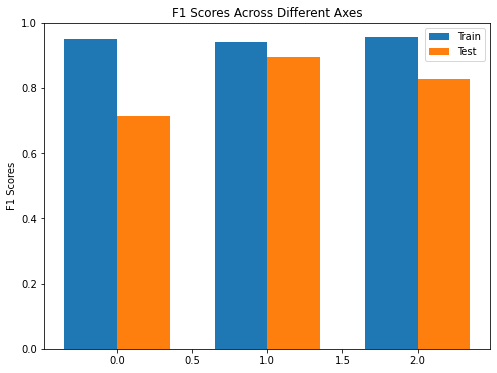

In [ ]:
#Random Forest Plot
labels = ['Disagreement', 'Civility', 'Serious']
train = [rf_results['ag_train'].mean(), rf_results['ci_train'].mean(), rf_results['se_train'].mean()]
#test = [rf_results['ag_test'].mean(), rf_results['ci_test'].mean(), rf_results['se_test'].mean()]
test = [rf_test['AG'], rf_test['CI'],rf_test['SE']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train, width, label='Train')
rects2 = ax.bar(x + width/2, test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Scores')
ax.set_ylim(0,1)
ax.set_title('F1 Scores Across Different Axes')
ax.set_xticks(x, labels)
ax.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


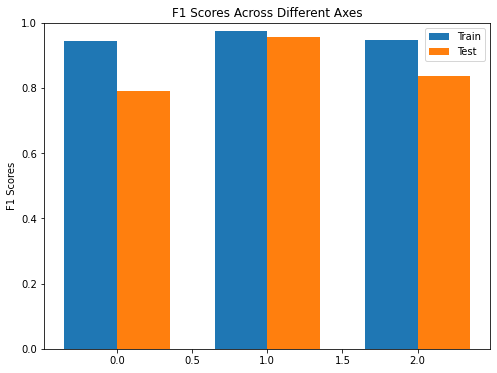

In [ ]:
#NN Plot
labels = ['Disagreement', 'Civility', 'Serious']
train = [nn_results['ag_train'].mean(), nn_results['ci_train'].mean(), nn_results['se_train'].mean()]
#test = [nn_results['ag_test'].mean(), nn_results['ci_test'].mean(), nn_results['se_test'].mean()]
test = [nn_test['AG'], nn_test['CI'],nn_test['SE']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train, width, label='Train')
rects2 = ax.bar(x + width/2, test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Scores')
ax.set_ylim(0,1)
ax.set_title('F1 Scores Across Different Axes')
ax.set_xticks(x, labels)
ax.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


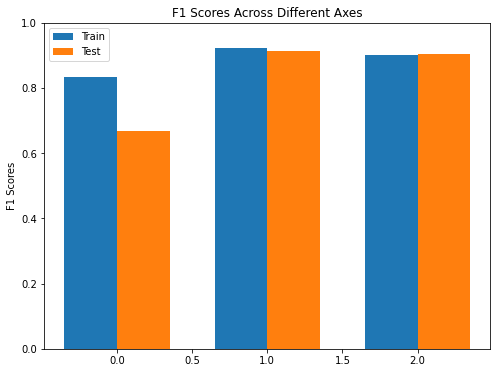

In [ ]:
#MT Plot
labels = ['Disagreement', 'Civility', 'Serious']
train = [mt_results['ag_train'].mean(), mt_results['ci_train'].mean(), mt_results['se_train'].mean()]
#test = [mt_results['ag_test'].mean(), mt_results['ci_test'].mean(), mt_results['se_test'].mean()]
test = [mt_test['AG'], mt_test['CI'],mt_test['SE']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train, width, label='Train')
rects2 = ax.bar(x + width/2, test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1 Scores')
ax.set_ylim(0,1)
ax.set_title('F1 Scores Across Different Axes')
ax.set_xticks(x, labels)
ax.legend()

plt.show()

In [ ]:
print(nn_results['ag_test'].mean(), nn_results['ci_test'].mean(), nn_results['se_test'].mean())
mt_results['ag_test'].mean(), mt_results['ci_test'].mean(), mt_results['se_test'].mean()

0.695964343094195 0.8532919356294684 0.8440813662479432


(0.6591513417932182, 0.8529132018090557, 0.8476557016420688)

Training ANN

CLASSIFYING THE REST OF THE DATASET

In [ ]:
#get full data
full_data = pd.read_excel('final_cleaned_data.xlsx')
full_data = full_data.dropna(subset = ['C1', 'C2', 'C3']).reset_index(drop=True)

In [ ]:
#Get Embeddings
for i in full_data.index:
  try:
    c1 = tokenizer(full_data.loc[i, 'C1'], return_tensors="pt")
    c2 = tokenizer(full_data.loc[i, 'C2'], return_tensors="pt")
    c3 = tokenizer(full_data.loc[i, 'C3'], return_tensors="pt")
  except:
    continue
  try:
    emb1, emb2, emb3 = model(**c1, output_hidden_states=True)['last_hidden_state'][:,0,:].detach().numpy(), model(**c2, output_hidden_states=True)['last_hidden_state'][:,0,:].detach().numpy(), model(**c3, output_hidden_states=True)['last_hidden_state'][:,0,:].detach().numpy()
  except:
    continue
  chain_emb = np.concatenate([emb1, emb2, emb3], axis = 1)
  if i == 0:
    X_full = chain_emb
    X_id = [i]
  else:
    X_full = np.concatenate([X_full, chain_emb])
    X_id.append(i)
  if i %500 == 0:
    print(f'Finished {i}')

Finished 0
Finished 500


Token indices sequence length is longer than the specified maximum sequence length for this model (1451 > 512). Running this sequence through the model will result in indexing errors


Finished 1000
Finished 1500
Finished 2000
Finished 2500
Finished 3000
Finished 3500
Finished 4000
Finished 4500
Finished 5000
Finished 5500
Finished 6000
Finished 6500
Finished 7000
Finished 7500
Finished 8000
Finished 8500
Finished 9000
Finished 9500
Finished 10000
Finished 10500
Finished 11000
Finished 11500
Finished 12000
Finished 12500


In [ ]:
import pickle

In [ ]:
out = {'ind':X_id, 'emb':X_full}

In [ ]:
with open('final_emb.pickle', 'wb') as handle:
    pickle.dump(out, handle, protocol=pickle.HIGHEST_PROTOCOL)